# Training a LSTM

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

%pip install matplotlib kagglehub
import matplotlib.pyplot as plt

import kagglehub

# Download latest version
path = kagglehub.dataset_download("tarunpaparaju/apple-aapl-historical-stock-data")

print("Path to dataset files:", path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 112.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 53.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [kagglehub]11 [kagglehub]]
Note: you may need to restart the kernel to use updated packages.


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 49.5k/49.5k [00:00<00:00, 561kB/s]

Extracting files...
Path to dataset files: /home/onyxia/.cache/kagglehub/datasets/tarunpaparaju/apple-aapl-historical-stock-data/versions/1


### Cleaning APPLE data

In [3]:
def clean_df(df):
    """
    Convertit toutes les colonnes contenant des valeurs en dollars (avec $) en float.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant les colonnes à convertir.

    Retourne:
    pd.DataFrame: DataFrame avec les colonnes converties en float.
    """
    df_converti = df.copy()
    for colonne in df_converti.columns:
        if colonne == 'Date':
            continue
        # Vérifie si la première valeur de la colonne contient un $
        if df_converti[colonne].dtype == object and df_converti[colonne].str.contains('$', na=False).any():
            # Supprime le symbole $ et convertit en float
            df_converti[colonne] = df_converti[colonne].str.replace('$', '', regex=False).astype(float)
    return df_converti

def compute_growth(df):
    """
    Convertit toutes les colonnes contenant des valeurs en dollars (avec $) en float.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant les colonnes à convertir.

    Retourne:
    pd.DataFrame: DataFrame avec les colonnes converties en float.
    """
    df_converti = df.copy()
    for colonne in df_converti.columns:
        if colonne == 'Date':
            continue
        # Vérifie si la première valeur de la colonne contient un $
        if df_converti[colonne].dtype == object and df_converti[colonne].str.contains('$', na=False).any():
            # Supprime le symbole $ et convertit en float
            df_converti[colonne] = df_converti[colonne].str.replace('$', '', regex=False).astype(float)
    return df_converti

In [4]:
dataset_path = path+'/HistoricalQuotes.csv'

df = pd.read_csv(dataset_path)
df = df.rename(str.strip, axis='columns')
df = clean_df(df)
df = df.iloc[::-1].reset_index(drop=True)
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,03/01/2010,29.8557,137312041,29.3928,29.9286,29.3500
1,03/02/2010,29.8357,141486282,29.9900,30.1186,29.6771
2,03/03/2010,29.9043,92846488,29.8486,29.9814,29.7057
3,03/04/2010,30.1014,89591907,29.8971,30.1314,29.8043
4,03/05/2010,31.2786,224647427,30.7057,31.3857,30.6614


In [122]:
dataset_path_stock = 'data/stock_exchange.csv'

df_stock = pd.read_csv(dataset_path_stock)
df_stock = df_stock.rename(str.strip, axis='columns')
df_stock.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [138]:
def clean_df_stock(df):
    # Convert dollar-formatted columns to numeric; handle non-numeric identifiers
    df_converti = df.copy()
    
    # Drop non-numeric identifier columns
    cols_to_drop = []
    if 'date' in df_converti.columns or 'Date' in df_converti.columns:
        cols_to_drop.extend([col for col in df_converti.columns if col.lower() == 'date'])
    if 'index' in df_converti.columns or 'Index' in df_converti.columns:
        cols_to_drop.extend([col for col in df_converti.columns if col.lower() == 'index'])
    
    if cols_to_drop:
        df_converti = df_converti.drop(columns=cols_to_drop)

    # Convert object columns to numeric (strip $ and coerce)
    for colonne in df_converti.columns:
        if df_converti[colonne].dtype == object:
            df_converti[colonne] = df_converti[colonne].str.replace('$', '', regex=False)
            df_converti[colonne] = pd.to_numeric(df_converti[colonne], errors='coerce')

    # Drop rows with NaN values
    df_converti = df_converti.dropna()
    
    # Use case-insensitive column matching
    col_map = {col.lower(): col for col in df_converti.columns}
    required_cols = {'open', 'high', 'low', 'close', 'volume'}
    
    if required_cols.issubset(set(col_map.keys())):
        # Map lowercase to actual column names
        index_to_data = {
            i: (
                row[col_map['open']], 
                row[col_map['high']], 
                row[col_map['low']], 
                row[col_map['close']], 
                row[col_map['volume']]
            )
            for i, row in df_converti.iterrows()
        }
    else:
        index_to_data = {}
    
    return df_converti, index_to_data

df_stock_cleaned, index_to_data = clean_df_stock(df_stock)
print(f"Cleaned df shape: {df_stock_cleaned.shape}, dict entries: {len(index_to_data)}")
df_stock_cleaned.head()


Cleaned df shape: (104224, 7), dict entries: 104224


,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [ ]:
def prepare_ticker_data(df_stock):
    """
    Convert stock exchange DataFrame into nested dictionary structure.
    
    Parameters:
    df_stock (pd.DataFrame): DataFrame with 'Index' column for ticker symbol and OHLC price columns
    
    Returns:
    dict: {ticker: {Open: np.array([...]), High: np.array([...]), Low: np.array([...]), Close: np.array([...])}}
    """
    ticker_to_data = {}
    
    for ticker in df_stock['Index'].unique():
        # Filter data for this ticker
        df_ticker = df_stock[df_stock['Index'] == ticker].copy().reset_index(drop=True)
        
        # Clean this ticker data
        df_clean = df_ticker.copy()
        
        # Drop date and index columns
        cols_to_drop = [col for col in df_clean.columns if col.lower() in ['date', 'index']]
        if cols_to_drop:
            df_clean = df_clean.drop(columns=cols_to_drop)
        
        # Convert object columns to numeric
        for col in df_clean.columns:
            if df_clean[col].dtype == object:
                df_clean[col] = df_clean[col].str.replace('$', '', regex=False)
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
        # Drop NaN rows
        df_clean = df_clean.dropna()
        
        # Create sub-dictionary for this ticker with column arrays
        ticker_dict = {
            'Open': np.array(df_clean['Open'].values, dtype=np.float32),
            'High': np.array(df_clean['High'].values, dtype=np.float32),
            'Low': np.array(df_clean['Low'].values, dtype=np.float32),
            'Close': np.array(df_clean['Close'].values, dtype=np.float32)
        }
        
        ticker_to_data[ticker] = ticker_dict
    
    return ticker_to_data

# Call the function to create the dictionary
ticker_to_data = prepare_ticker_data(df_stock)

print("Structure: {ticker: {Open: np.array([...]), High: np.array([...]), Low: np.array([...]), Close: np.array([...])}}\n")
print(f"Tickers in dictionary: {list(ticker_to_data.keys())}\n")

# Show sample data
for ticker in ['HSI', 'NYA', 'N225']:
    if ticker in ticker_to_data:
        print(f"{ticker}:")
        for col in ['Open', 'High', 'Low', 'Close']:
            arr = ticker_to_data[ticker][col]
            print(f"  {col}: {len(arr)} values, first 5: {arr[:5]}")
        print()
df_stock_cleaned = prepare_ticker_data(df_stock)


Structure: {ticker: {Open: np.array([...]), High: np.array([...]), Low: np.array([...]), Close: np.array([...])}}

Tickers in dictionary: ['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ', 'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO']

HSI:
  Open: 8492 values, first 5: [2568.3 2540.1 2552.4 2583.9 2607.1]
  High: 8492 values, first 5: [2568.3 2540.1 2552.4 2583.9 2607.1]
  Low: 8492 values, first 5: [2568.3 2540.1 2552.4 2583.9 2607.1]
  Close: 8492 values, first 5: [2568.3 2540.1 2552.4 2583.9 2607.1]

NYA:
  Open: 13947 values, first 5: [528.69 527.21 527.84 531.12 532.07]
  High: 13947 values, first 5: [528.69 527.21 527.84 531.12 532.07]
  Low: 13947 values, first 5: [528.69 527.21 527.84 531.12 532.07]
  Close: 13947 values, first 5: [528.69 527.21 527.84 531.12 532.07]

N225:
  Open: 13874 values, first 5: [1257.72 1263.99 1274.27 1286.43 1288.54]
  High: 13874 values, first 5: [1257.72 1263.99 1274.27 1286.43 1288.54]
  Low: 13874 values, first 5: [1257.72

dict_keys(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ', 'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'])

In [147]:
df_stock_cleaned['HSI']

{'Open': array([ 2568.3 ,  2540.1 ,  2552.4 , ..., 28998.39, 29219.46, 29225.46],
       shape=(8492,), dtype=float32),
 'High': array([ 2568.3 ,  2540.1 ,  2552.4 , ..., 29157.95, 29336.13, 29225.46],
       shape=(8492,), dtype=float32),
 'Low': array([ 2568.3 ,  2540.1 ,  2552.4 , ..., 28950.72, 29033.72, 28909.52],
       shape=(8492,), dtype=float32),
 'Close': array([ 2568.3 ,  2540.1 ,  2552.4 , ..., 29113.2 , 29124.41, 29151.8 ],
       shape=(8492,), dtype=float32)}

In [ ]:
aapl_open = df['Open']
aapl_close = df['Close/Last']
aapl_low = df['Low']
aapl_high = df['High']
aapl_volume = df['Volume']

aapl_growth = aapl_close.pct_change() * 100
aapl_growth = aapl_growth.fillna(0.0)


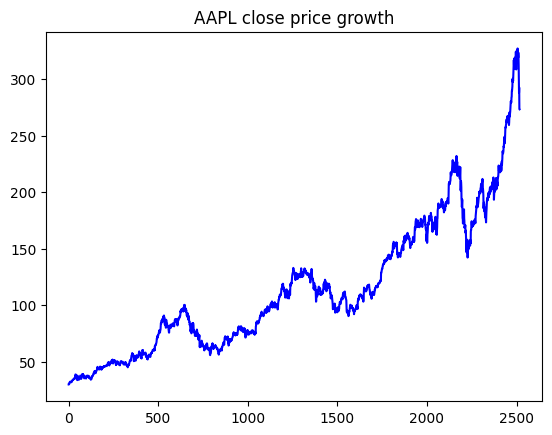

In [8]:
plt.plot(aapl_close, '-b')
plt.title('AAPL close price growth')
plt.show()

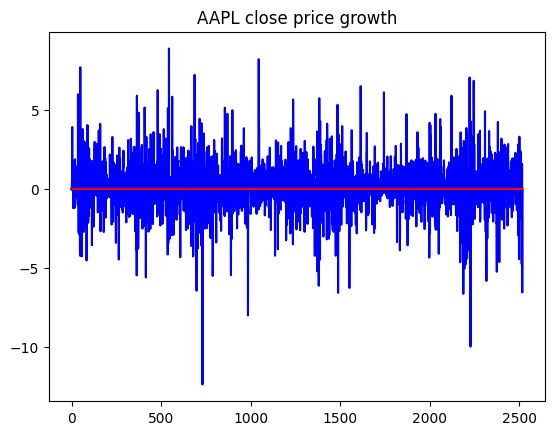

In [9]:
plt.plot(aapl_growth, '-b')
plt.plot([0]*len(aapl_growth), '-r')
plt.title('AAPL close price growth')
plt.show()

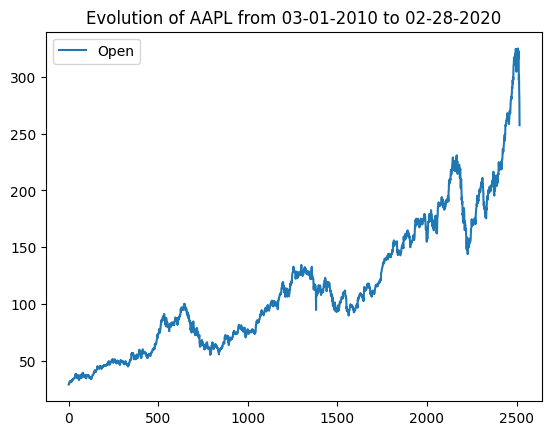

In [10]:
plt.plot(aapl_open, label = 'Open')

plt.legend()
plt.title('Evolution of AAPL from 03-01-2010 to 02-28-2020')
plt.show()

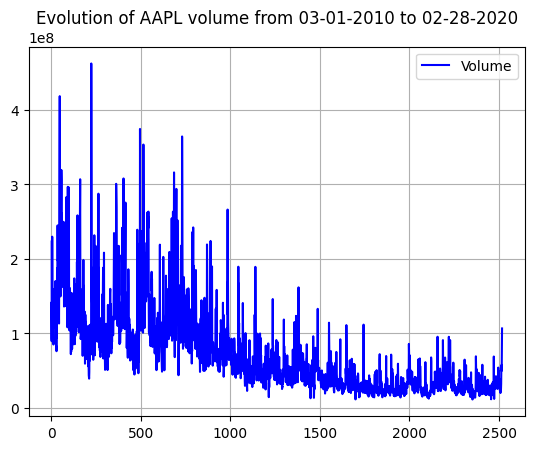

In [11]:
plt.plot(aapl_volume, '-b', label = 'Volume')


plt.legend()
plt.grid()
plt.title('Evolution of AAPL volume from 03-01-2010 to 02-28-2020')
plt.show()

In [148]:
close = df[['Close/Last']].values

def prep_data0(data):
    n = len(data)
    train_size = int(n * 0.8)
    test_size = n - train_size
    variations  = np.diff(data, axis=0)
    data = data[:-1]
    train_data = data[:train_size]
    test_data = data[train_size:]
    train_labels = variations[:train_size]
    test_labels = variations[train_size:]
    return train_data, test_data, train_labels, test_labels

In [150]:
def prep_data(data, labels, data_size):
    n = len(data)
    data_sequences = []
    label_sequences = []
    for i in range(0, n - data_size + 1):
        data_seq = data[i:i+data_size]
        norm = np.sum(data_seq)/data_size
        data_seq = data_seq/norm
        label_seq = labels[i+data_size-1]/norm  # label corresponding to the last element in the sequence
        data_sequences.append(data_seq)
        label_sequences.append(label_seq)

    return np.array(data_sequences), np.array(label_sequences)

def prep_dataloader(data, window_size):
    train_data, test_data, train_labels, test_labels = prep_data0(data)
    train_sequences, train_label_sequences = prep_data(train_data, train_labels, window_size)
    test_sequences, test_label_sequences = prep_data(test_data, test_labels, window_size)
    return train_sequences, test_sequences, train_label_sequences, test_label_sequences

combined_train_data_seq, combined_test_data_seq, combined_train_labels_seq, combined_test_labels_seq = prep_dataloader(close.flatten(), window_size=20)
for ind in df_stock_cleaned.keys():
    train_data_seq, test_data_seq, train_labels_seq, test_labels_seq = prep_dataloader(df_stock_cleaned[ind]['Close'], window_size=20)
    combined_train_data_seq = np.concatenate((combined_train_data_seq, train_data_seq), axis=0)
    combined_test_data_seq = np.concatenate((combined_test_data_seq, test_data_seq), axis=0)
    combined_train_labels_seq = np.concatenate((combined_train_labels_seq, train_labels_seq), axis=0)
    combined_test_labels_seq = np.concatenate((combined_test_labels_seq, test_labels_seq), axis=0)
print(f"Train data shape: {combined_train_data_seq.shape}, Train labels shape: {combined_train_labels_seq.shape}")


Train data shape: (85121, 20), Train labels shape: (85121,)


#### Test with LSTM


In [14]:
class SMOLTradingBOT(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SMOLTradingBOT, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 4*hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(4*hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        h1 = torch.zeros(1, x.size(0), 4*self.hidden_size).to(x.device)
        c1 = torch.zeros(1, x.size(0), 4*self.hidden_size).to(x.device)
        h2 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c2 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out, _ = self.lstm2(out, (h1, c1))
        out, _ = self.lstm3(out, (h2, c2))
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
class StrongLinear(nn.Module):
    def __init__(self, input_size):
        super(StrongLinear, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [15]:
def train_lstm(model, train_data, label_data, num_epochs=100, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    device = next(model.parameters()).device

    model.train()
    for epoch in range(num_epochs):
        inputs = torch.tensor(train_data, dtype=torch.float32).unsqueeze(-1).to(device)
        labels = torch.tensor(label_data, dtype=torch.long).to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SMOLTradingBOT(input_size=1, hidden_size=100, output_size=2).to(device)
train_lstm(model, train_data, train_labels, num_epochs=10, learning_rate=0.01)

Epoch [10/10], Loss: 0.6922


SMOLTradingBOT(
  (lstm): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 400, batch_first=True)
  (lstm3): LSTM(400, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [16]:
def test_lstm(model, test_data, label_data):
    model.eval()
    device = next(model.parameters()).device
    
    inputs = torch.tensor(test_data, dtype=torch.float32).unsqueeze(-1).to(device)
    labels = torch.tensor(label_data, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
    print(predicted)

    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

test_lstm(model, test_data, test_labels)
model0 = SMOLTradingBOT(input_size=1, hidden_size=50, output_size=2)
test_lstm(model0, test_data, test_labels)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

0.5456349206349206

#### Linear Model Training and Testing

In [17]:
def train_linear(model, train_data, label_data, num_epochs=100, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    device = next(model.parameters()).device

    model.train()
    for epoch in range(num_epochs):
        inputs = torch.tensor(train_data, dtype=torch.float32).to(device)
        labels = torch.tensor(label_data, dtype=torch.long).to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

def test_linear(model, test_data, label_data):
    model.eval()
    device = next(model.parameters()).device
    
    inputs = torch.tensor(test_data, dtype=torch.float32).to(device)
    labels = torch.tensor(label_data, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
    print(predicted)

    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [18]:
seq_data, seq_labels = prep_data(data, labels, data_size=20)
seq_test_data, seq_test_labels = prep_data(test_data, test_labels, data_size=20)
short_seq_data, short_seq_labels = prep_data(data, labels, data_size=10)
short_test_data, short_test_labels = prep_data(test_data, test_labels, data_size=10)


In [19]:
for i in range(10,15):
    print(seq_data[i].T,seq_data[i+1][-1],seq_labels[i])

[[0.96457636 0.96720671 0.96578294 0.9680664  0.95772598 0.96849775
  0.98405364 0.98840639 0.97668744 0.99500037 1.00142241 1.01630864
  1.01266777 1.01684859 1.02770784 1.03223253 1.03679945 1.03400018
  1.04192743 1.04408119]] [1.04051679] 0.03016459765177657
[[0.96334811 0.96193002 0.96420437 0.9539052  0.964634   0.98012783
  0.98446321 0.97279102 0.99103089 0.99742731 1.01225415 1.00862781
  1.01279194 1.02360788 1.02811452 1.03266322 1.02987511 1.03777074
  1.0399159  1.04051679]] [1.04972657] 0.030044258196749638
[[0.95756528 0.95982931 0.94957687 0.96025699 0.97568051 0.97999623
  0.968377   0.9865341  0.9929015  1.00766107 1.00405118 1.00819642
  1.01896327 1.02344946 1.02797753 1.02520207 1.03306187 1.0351973
  1.03579546 1.04972657]] [1.05792118] 0.029907932914712
[[0.95477089 0.94457249 0.95519632 0.97053856 0.97483153 0.96327353
  0.98133495 0.98766879 1.00235057 0.99875971 1.0028831  1.01359322
  1.01805576 1.02255996 1.01979913 1.02761751 1.02974169 1.03033669
  1.04419

In [20]:
class DeepLinear(nn.Module):
    def __init__(self, input_size):
        super(DeepLinear, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 265)
        self.fc5 = nn.Linear(265, 128)
        self.fc6 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
deep_model = DeepLinear(input_size=20)
train_linear(deep_model, seq_data.reshape(len(seq_data), -1), seq_labels, num_epochs=100, learning_rate=0.001)
test_linear(deep_model, seq_test_data.reshape(len(seq_test_data), -1), seq_test_labels) 


Epoch [10/100], Loss: 0.0008
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1.0

In [21]:
class DeepLinear(nn.Module):
    def __init__(self, input_size):
        super(DeepLinear, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512,512)
        self.fc6 = nn.Linear(512, 2)
        self.dropout1 = nn.Dropout(p = 0.3)
        self.dropout2 = nn.Dropout(p = 0.3)
        self.dropout3 = nn.Dropout(p = 0.3)
        self.dropout4 = nn.Dropout(p = 0.3)
        self.dropout5 = nn.Dropout(p = 0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.relu(self.fc5(x))
        x = self.dropout5(x)
        x = self.fc6(x)
        return x
    
deep_model = DeepLinear(input_size=20)
train_linear(deep_model, seq_data.reshape(len(seq_data), -1), seq_labels, num_epochs=100, learning_rate=0.0001)
test_linear(deep_model, seq_test_data.reshape(len(seq_test_data), -1), seq_test_labels) 


Epoch [10/100], Loss: 0.5572
Epoch [20/100], Loss: 0.2289
Epoch [30/100], Loss: 0.0100
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1.0

#### Classification with amplitude

In [ ]:
class ClassifierAmplitude(nn.Module):
    def __init__(self, input_size):
        super(ClassifierAmplitude, self).__init__()
        self.fc1 = nn.Linear(input_size, 512, bias =True)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 512)
        self.fc7 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256, bias =True)
        self.fc5 = nn.Linear(256, 1, bias =True)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p = 0.3)
        self.dropout2 = nn.Dropout(p = 0.1)

        # Better initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.relu(self.fc3(x))
        x = self.dropout1(x)
        x = self.relu(self.fc6(x))
        x = self.dropout1(x)
        x = self.relu(self.fc7(x))
        x = self.dropout1(x)
        x = self.relu(self.fc4(x))
        x = self.dropout2(x)
        x = self.fc5(x)
        return x


def train_amplitude(model, train_loader, num_epochs=100, learning_rate=0.001,lossf=torch.nn.MSELoss()):
    criterion_regression = lossf
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    device = next(model.parameters()).device
    model.train()
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    for epoch in range(num_epochs):
        # Iterate over batches
        for inputs, labels_regression in train_loader:
            inputs = inputs.to(device)
            labels_regression = labels_regression.unsqueeze(-1).to(device)  

            # Forward pass
            outputs_regression = model(inputs)
            loss_regression = criterion_regression(outputs_regression, labels_regression)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss_regression.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_regression.item():.4f}')
    return model



def test_amplitude(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    total_loss = 0.0
    criterion_regression = torch.nn.MSELoss()
    with torch.no_grad():
        for inputs, labels_regression in test_loader:
            inputs = inputs.to(device)
            labels_regression = labels_regression.unsqueeze(-1).to(device)  

            outputs_regression = model(inputs)
            loss_regression = criterion_regression(outputs_regression, labels_regression)
            total_loss += loss_regression.item() * inputs.size(0)
    average_loss = total_loss / len(test_loader.dataset)
    print(f'Average MSE Loss: {average_loss:.4f}')
    return average_loss

In [38]:
def plot_trajectory(model,data,window_size):
    model.eval()
    device = next(model.parameters()).device
    
    # Real data
    plt.plot( np.arange(len(data)),data, label='Real Data', color='blue')

    # testing corrected data predictions
    n = len(data)
    train_size = int(n * 0.8)-window_size
    l = data[:train_size+window_size].flatten().tolist()
    print(f'len l1 = {len(l)}')
    with torch.no_grad():
        for i in range(train_size,n-window_size):
            input_seq = data[i:i+window_size].reshape(1,-1)
            norm = np.sum(input_seq)/window_size
            input_seq = input_seq/norm
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)
            predicted = model(input_tensor).cpu().numpy().flatten()[0]*norm
            l.append(predicted+data[i-1].item())
            if abs(predicted+data[i-1].item()-data[i+window_size-1].item())>300: break
            #plt.plot(i+window_size, predicted+data[i-1], color='orange')
    
    # testing uncorrected data predictions
    l2 = data[:train_size+window_size].flatten().tolist()
    print(f'len l2 = {len(l2)}')
    point = data[train_size-1].item()
    with torch.no_grad():
        for i in range(train_size,n-window_size):
            input_seq = data[i:i+window_size].reshape(1,-1)
            norm = np.sum(input_seq)/window_size
            input_seq = input_seq/norm
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)
            predicted = model(input_tensor).cpu().numpy().flatten()[0]*norm
            point = point + predicted
            l2.append(point)
            if abs(point-data[i+window_size-1].item())>300: break
            #plt.plot(i+window_size, point, color='red')

    # Model all by himself
    context_window = data[train_size:train_size+window_size].flatten().tolist()
    point = data[train_size-1].item()
    l3 = data[:train_size+window_size].flatten().tolist()
    with torch.no_grad():
        for i in range(train_size,n-window_size):
            input_seq = np.array(context_window[-window_size:]).reshape(1,-1)
            norm = np.sum(input_seq)/window_size
            input_seq = input_seq/norm
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)
            predicted = model(input_tensor).cpu().numpy().flatten()[0]*norm            
            point = point + predicted
            l3.append(point)
            context_window.append(predicted+context_window[-1])
            if abs(point-data[i+window_size-1].item())>300: break
            #plt.plot(i+window_size, point, color='green')
    
    plt.plot( np.arange(len(l)),l, label='Corrected Predictions', color='orange')
    plt.plot( np.arange(len(l2)),l2, label='Uncorrected Predictions', color='red')
    plt.plot( np.arange(len(l3)),l3, label='Autoregressive Predictions', color='green')
    #adding a line vertical to separate train and test
    plt.axvline(x=train_size+window_size, color='green', linestyle='--', label='Train/Test Split')
    plt.legend()
    plt.show()

In [158]:
# Creating the dataloader in the right device
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64
train_dataset = TensorDataset(torch.tensor(combined_train_data_seq, dtype=torch.float32).reshape(len(combined_train_data_seq), -1),
                              torch.tensor(combined_train_labels_seq, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(combined_test_data_seq, dtype=torch.float32).reshape(len(combined_test_data_seq), -1),
                             torch.tensor(combined_test_labels_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
window_size = 20
amplitude_model = ClassifierAmplitude(input_size=window_size)

def train_and_test_and_plot(model, window_size,train_loader,test_loader):
    train_amplitude(model, train_loader, num_epochs=5000, learning_rate=0.001,lossf=nn.L1Loss())
    test_amplitude(model, test_loader)
    plot_trajectory(model, close[:-1], window_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setting all to device

model = amplitude_model.to(device)
train_and_test_and_plot(model, window_size,train_loader,test_loader)

TypeError: train_and_test_and_plot() missing 2 required positional arguments: 'data_test' and 'labels_test'

len l1 = 2013


len l2 = 2013


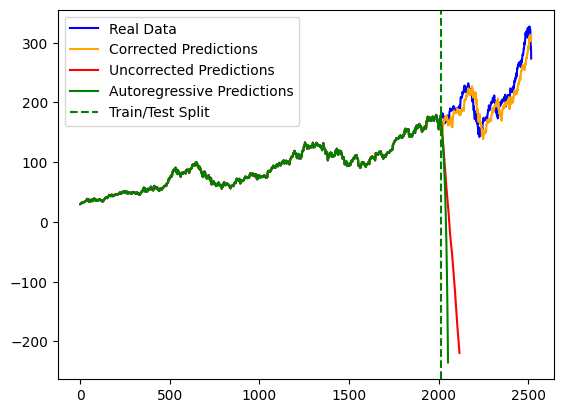

In [25]:
plot_trajectory(data=data,model=amplitude_model,window_size=window_size)

In [151]:
window_size = 150
#amplitude_model = ClassifierAmplitude(input_size=window_size)

data_train_amplitude = data_train_amplitude.reshape(-1)
data_test_amplitude = data_test_amplitude.reshape(-1)
amplitude_train_labels = data_train_amplitude
amplitude_test_labels = data_test_amplitude

seq_amplitude_data, seq_amplitude_labels = prep_data(train_data, amplitude_train_labels, data_size=window_size)
seq_test_amplitude_data, seq_test_amplitude_labels = prep_data(test_data, amplitude_test_labels, data_size=window_size)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setting all to device

model = amplitude_model.to(device)
seq_amplitude_data = torch.tensor(seq_amplitude_data, dtype=torch.float32).to(device)
seq_amplitude_labels = torch.tensor(seq_amplitude_labels, dtype=torch.float32).to(device)
seq_test_amplitude_data = torch.tensor(seq_test_amplitude_data, dtype=torch.float32).to(device)
seq_test_amplitude_labels = torch.tensor(seq_test_amplitude_labels, dtype=torch.float32).to(device)




print(seq_amplitude_data.reshape(len(seq_amplitude_data), -1).device, amplitude_train_labels.device)
train_amplitude(amplitude_model, seq_amplitude_data.reshape(len(seq_amplitude_data), -1), seq_amplitude_labels, num_epochs=10000, learning_rate=0.000001,lossf=nn.L1Loss())
test_amplitude(amplitude_model, seq_test_amplitude_data.reshape(len(seq_test_amplitude_data), -1), seq_test_amplitude_labels)
plot_trajectory(amplitude_model, data, window_size)


cpu cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1864x150 and 20x512)